<a href="https://colab.research.google.com/github/ZakariaBenarbia/TP-Programmation-Orient-e-Objet/blob/main/programme_POO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please upload your Excel file for the Male Infertility Dataset (e.g., Male Infertility Data.xlsx):


Saving Male Infertility Data.xlsx to Male Infertility Data.xlsx
File 'Male Infertility Data.xlsx' uploaded and saved.
Data loaded successfully. Shape: (200, 54)
Data cleaned.
Plotting one graph (Histogram of Age) before clustering:


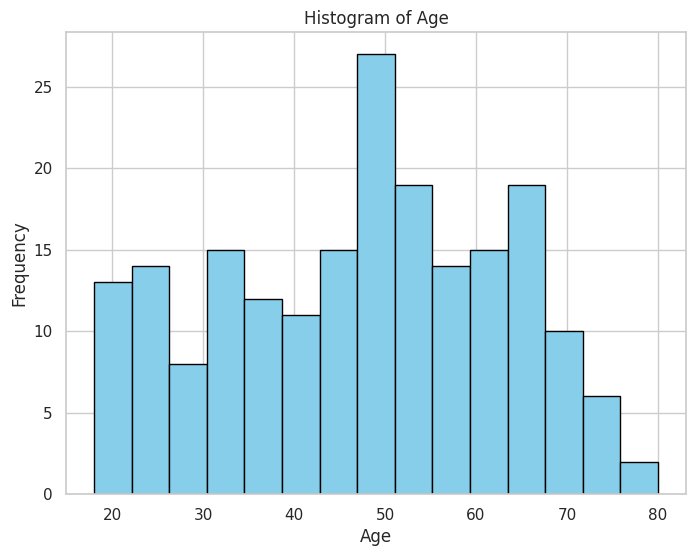

Descriptive Statistics:
               S/N     Consent         Age Ethnicity    Religion  \
count   200.000000  200.000000  200.000000       200  200.000000   
unique         NaN         NaN         NaN        61         NaN   
top            NaN         NaN         NaN      Igbo         NaN   
freq           NaN         NaN         NaN        52         NaN   
mean    100.500000    0.960000   47.295000       NaN    1.265000   
std      57.879185    0.196451   15.436626       NaN    0.453656   
min       1.000000    0.000000   18.000000       NaN    1.000000   
25%      50.750000    1.000000   34.750000       NaN    1.000000   
50%     100.500000    1.000000   48.000000       NaN    1.000000   
75%     150.250000    1.000000   60.250000       NaN    2.000000   
max     200.000000    1.000000   80.000000       NaN    3.000000   

        Relationship status  highest level of education  occupational status  \
count            200.000000                  200.000000           200.000000   

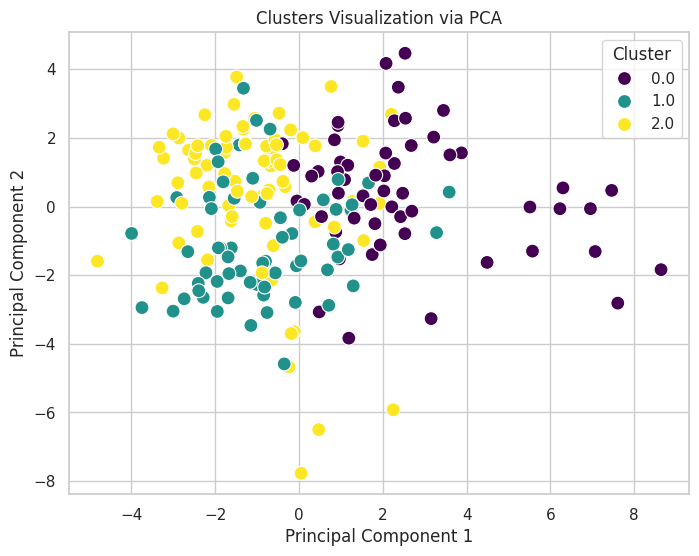

In [1]:
# Enable inline plotting in Google Colab.
%matplotlib inline

# Import required libraries.
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import io
from google.colab import files

# Additional libraries for clustering and preprocessing.
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# =============================================================================
# DataAnalyzer Class: Chargement et Nettoyage du Dataset
# =============================================================================
class DataAnalyzer:
    """
    Cette classe charge le fichier Excel et nettoie le dataset en remplissant
    les valeurs manquantes (médiane pour les valeurs numériques et mode pour les valeurs catégorielles).
    """
    def __init__(self, filepath):
        self.filepath = filepath
        self.data = None

    def load_data(self):
        """Charge le dataset depuis un fichier Excel."""
        try:
            self.data = pd.read_excel(self.filepath)
            print(f"Data loaded successfully. Shape: {self.data.shape}")
        except Exception as e:
            print("Error loading data:", e)

    def clean_data(self):
        """Nettoie le dataset en remplissant les valeurs manquantes."""
        if self.data is not None:
            numeric_cols = self.data.select_dtypes(include=['int64', 'float64']).columns
            for col in numeric_cols:
                self.data[col] = self.data[col].fillna(self.data[col].median())
            categorical_cols = self.data.select_dtypes(include=['object']).columns
            for col in categorical_cols:
                self.data[col] = self.data[col].fillna(self.data[col].mode()[0])
            print("Data cleaned.")
        else:
            print("Data not loaded.")

    def descriptive_statistics(self):
        """Affiche les statistiques descriptives."""
        if self.data is not None:
            print("Descriptive Statistics:")
            print(self.data.describe(include="all"))
        else:
            print("Data not loaded.")

    def missing_values_report(self):
        """Affiche le nombre de valeurs manquantes par colonne."""
        if self.data is not None:
            print("Missing Values Report:")
            print(self.data.isnull().sum())
        else:
            print("Data not loaded.")

    def filter_data(self, column, condition):
        """Retourne un sous-ensemble du dataset basé sur une condition."""
        if self.data is not None:
            filtered = self.data[self.data[column].apply(condition)]
            print(f"Filtered data based on {column}: shape {filtered.shape}")
            return filtered
        else:
            print("Data not loaded.")
            return None

# =============================================================================
# Visualizer Class: Visualisation du Dataset
# =============================================================================
class Visualizer:
    """
    Fournit des méthodes pour tracer des graphiques. Ici, nous utilisons un histogramme comme graphique d'exploration.
    """
    def __init__(self, dataframe):
        self.data = dataframe
        sns.set(style="whitegrid")

    def plot_histogram(self, column, bins=10):
        """Trace un histogramme pour une colonne numérique."""
        if self.data is not None and column in self.data.columns:
            plt.figure(figsize=(8, 6))
            plt.hist(self.data[column], bins=bins, color='skyblue', edgecolor='black')
            plt.title(f"Histogram of {column}")
            plt.xlabel(column)
            plt.ylabel("Frequency")
            plt.show()
        else:
            print(f"Column {column} not found or data is empty.")

    def plot_clusters(self, X_pca, cluster_labels):
        """Trace une visualisation des clusters (après réduction PCA)."""
        plt.figure(figsize=(8,6))
        sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=cluster_labels, palette='viridis', s=100)
        plt.title("Clusters Visualization via PCA")
        plt.xlabel("Principal Component 1")
        plt.ylabel("Principal Component 2")
        plt.legend(title="Cluster")
        plt.show()

# =============================================================================
# FullDatasetClustering Class (Optionnel)
# =============================================================================
class FullDatasetClustering:
    """
    Prend en entrée le dataset nettoyé, encode les variables catégorielles via one-hot encoding,
    standardise les données et applique le clustering KMeans.
    Ensuite, réduit la dimension via PCA pour la visualisation.
    """
    def __init__(self, dataframe):
        self.raw_data = dataframe.copy()
        self.data = None  # Contiendra le DataFrame prétraité
        self.scaler = StandardScaler()
        self.kmeans_model = None
        self.cluster_labels = None

    def preprocess(self):
        """Effectue le prétraitement: séparation des colonnes numériques et catégorielles, encodage des catégoriques, et concaténation."""
        numeric_cols = self.raw_data.select_dtypes(include=['int64','float64']).columns.tolist()
        categorical_cols = self.raw_data.select_dtypes(include=['object']).columns.tolist()

        print("Numeric columns found:", numeric_cols)
        print("Categorical columns found:", categorical_cols)

        df_numeric = self.raw_data[numeric_cols].copy()
        if categorical_cols:
            df_categorical = pd.get_dummies(self.raw_data[categorical_cols], drop_first=True)
        else:
            df_categorical = pd.DataFrame()

        self.data = pd.concat([df_numeric, df_categorical], axis=1)
        print("Preprocessing complete. Combined data shape:", self.data.shape)
        return self.data

    def run_clustering(self, n_clusters=3):
        """Standardise et applique KMeans sur les données prétraitées, puis affecte les labels aux observations."""
        if self.data is None:
            self.preprocess()

        X = self.data.dropna()
        X_scaled = self.scaler.fit_transform(X)

        self.kmeans_model = KMeans(n_clusters=n_clusters, random_state=42)
        self.cluster_labels = self.kmeans_model.fit_predict(X_scaled)

        # Ajoute les labels des clusters au DataFrame
        self.data.loc[X.index, 'Cluster'] = self.cluster_labels
        print("Clustering completed. Cluster counts:")
        print(pd.Series(self.cluster_labels).value_counts())
        print("Cluster centroids (in standardized feature space):")
        print(self.kmeans_model.cluster_centers_)
        return self.data

    def visualize_clusters(self, n_components=2):
        """Réduit les dimensions avec PCA et retourne les résultats pour visualisation."""
        if self.data is None or 'Cluster' not in self.data.columns:
            print("Please run clustering first.")
            return

        X = self.data.drop(columns=['Cluster']).dropna()
        X_scaled = self.scaler.transform(X)
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_scaled)
        cluster_labels = self.data.loc[X.index, 'Cluster']
        return X_pca, cluster_labels

# =============================================================================
# Main Function: Orchestration
# =============================================================================
def main():
    # File upload in Google Colab.
    print("Please upload your Excel file for the Male Infertility Dataset (e.g., Male Infertility Data.xlsx):")
    uploaded = files.upload()
    for fn in uploaded.keys():
        with open(fn, 'wb') as f:
            f.write(uploaded[fn])
        filepath = fn
        print(f"File '{fn}' uploaded and saved.")
        break

    # Load and clean the dataset.
    analyzer = DataAnalyzer(filepath)
    analyzer.load_data()
    analyzer.clean_data()

    # Plot only one graph before clustering: Histogram of Age.
    print("Plotting one graph (Histogram of Age) before clustering:")
    viz = Visualizer(analyzer.data)
    viz.plot_histogram("Age", bins=15)

    # Afficher les statistiques descriptives et le report des valeurs manquantes.
    analyzer.descriptive_statistics()
    analyzer.missing_values_report()

    # Run full-dataset clustering.
    full_clusterer = FullDatasetClustering(analyzer.data)
    full_clusterer.preprocess()
    full_clusterer.run_clustering(n_clusters=3)
    X_pca, cluster_labels = full_clusterer.visualize_clusters(n_components=2)
    viz.plot_clusters(X_pca, cluster_labels)



# Execute the main function.
if __name__ == "__main__":
    main()
